In [2]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

device = "cuda" if torch.cuda.is_available() else "cpu"
gpt2 = GPT.from_pretrained('gpt2').to(device)


loading weights from pretrained gpt: gpt2


In [3]:
import tiktoken
import numpy as np
from tqdm import tqdm

enc = tiktoken.get_encoding("gpt2")
device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = "cuda" if "cuda" in device else "cpu"

def generate_from_model(model, context, max_tokens=100):
    model.eval()
    num_return_sequences = 4
    max_length = 32
    tokens = enc.encode("Hello, I'm a language model,")
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    xgen = tokens.to(device)
    sample_rng = torch.Generator(device=device)
    pbar = tqdm(total=max_length - xgen.size(1), desc="Generating")
    while xgen.size(1) < max_length:
        # forward the model to get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, loss = model(xgen) # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)
            pbar.update(1)
    pbar.close()
    # print the generated text
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        decoded = enc.decode(tokens)
        print(f"sample {i}: {decoded}")


generate_from_model(gpt2, "Hello, I'm a language model,")


Generating: 100%|██████████| 24/24 [00:01<00:00, 17.13it/s]

sample 0: Hello, I'm a language model, that you have got the capability of thinking about what I wrote up on the web. Now, by extension, this is
sample 1: Hello, I'm a language model, a framework for programming. I'm also a scientist."

He smiled and looked up at me. "How did
sample 2: Hello, I'm a language model, and I'm gonna use the language model."

A lot of the people at Google thought about such questions. And
sample 3: Hello, I'm a language model, there is a lot of work involved in developing that language, I wanted to do it myself, the only thing I have


In [ ]:
"""
Downloads and evaluates HellaSwag in Python.
https://github.com/rowanz/hellaswag

Example HellaSwag json item:

{"ind": 24, "activity_label": "Roof shingle removal", "ctx_a": "A man is sitting on a roof.", "ctx_b": "he", "ctx": "A man is sitting on a roof. he", "split": "val", "split_type": "indomain", "label": 3, "endings": ["is using wrap to wrap a pair of skis.", "is ripping level tiles off.", "is holding a rubik's cube.", "starts pulling up roofing on a roof."], "source_id": "activitynet~v_-JhWjGDPHMY"}

ind: dataset ID
activity_label: The ActivityNet or WikiHow label for this example
context: There are two formats. The full context is in ctx. When the context ends in an (incomplete) noun phrase, like for ActivityNet, this incomplete noun phrase is in ctx_b, and the context up until then is in ctx_a. This can be useful for models such as BERT that need the last sentence to be complete. However, it's never required. If ctx_b is nonempty, then ctx is the same thing as ctx_a, followed by a space, then ctx_b.
endings: a list of 4 endings. The correct index is given by label (0,1,2, or 3)
split: train, val, or test.
split_type: indomain if the activity label is seen during training, else zeroshot
source_id: Which video or WikiHow article this example came from

gpt2 (124M)
- eleuther harness reports acc 28.92%, acc_norm 31.14% (multiple choice style)
- this script: 10042 acc: 0.2859 acc_norm: 0.2955 (completion style)

gpt2-xl (1558M)
- eleuther harness reports acc 40.04%, acc_norm 50.89% (multiple choice style)
- this script: 10042 acc: 0.3842 acc_norm: 0.4893 (completion style)

The validation set of HellaSwag has a total of 10,042 examples.
"""

import os
import json
import pickle
import requests
import tiktoken
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel

from uq.acquisition_func import BeamScore
from uq.generate_with_uq import _enable_test_time_dropout

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = "cuda" if "cuda" in device else "cpu"
# -----------------------------------------------------------------------------
DATA_CACHE_DIR = os.path.join(os.getcwd(), "local/hellaswag")

def download_file(url: str, fname: str, chunk_size=1024):
    """Helper function to download a file from a given url"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(fname, "wb") as file, tqdm(
        desc=fname,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

hellaswags = {
    "train": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_train.jsonl",
    "val": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_val.jsonl",
    "test": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_test.jsonl",
}

enc = tiktoken.get_encoding("gpt2")

def download(split):
    """Downloads HellaSwag DATA_CACHE_DIR"""
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)
    data_url = hellaswags[split]
    data_filename = os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl")
    if not os.path.exists(data_filename):
        print(f"Downloading {data_url} to {data_filename}...")
        download_file(data_url, data_filename)

def render_example(example):
    """
    Given the example as a dictionary, render it as three torch tensors:
    - tokens (the tokens of context + completion, of size 4xN, as there are always 4 candidates)
    - mask (is 1 in the region of the candidate completion, where we evaluate likelihoods)
    - label (the index of the correct completion, which we hope has the highest likelihood)
    """
    ctx = example["ctx"]
    label = example["label"]
    endings = example["endings"]

    # data needed to reproduce this eval on the C size
    data = {
        "label": label,
        "ctx_tokens": None,
        "ending_tokens": [],
    }

    # gather up all the tokens
    ctx_tokens = enc.encode(ctx)
    data["ctx_tokens"] = ctx_tokens
    tok_rows = []
    mask_rows = []
    for end in endings:
        end_tokens = enc.encode(" " + end) # note: prepending " " because GPT-2 tokenizer
        tok_rows.append(ctx_tokens + end_tokens)
        mask_rows.append([0]*len(ctx_tokens) + [1]*len(end_tokens))
        data["ending_tokens"].append(end_tokens)

    # have to be careful during the collation because the number of tokens in each row can differ
    max_len = max(len(row) for row in tok_rows)
    tokens = torch.zeros((4, max_len), dtype=torch.long)
    mask = torch.zeros((4, max_len), dtype=torch.long)
    for i, (tok_row, mask_row) in enumerate(zip(tok_rows, mask_rows)):
        tokens[i, :len(tok_row)] = torch.tensor(tok_row)
        mask[i, :len(mask_row)] = torch.tensor(mask_row)

    return data, tokens, mask, label

def iterate_examples(split):
    # there are 10,042 examples in total in val
    download(split)
    with open(os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl"), "r") as f:
        for line in f:
            example = json.loads(line)
            yield example

@torch.no_grad()
def evaluate(model_type, device):

    torch.set_float32_matmul_precision('high') # use tf32
    model = GPT2LMHeadModel.from_pretrained(model_type)
    model.to(device)
    # model = torch.compile(model) # optionally torch compile the model

    num_correct_norm = 0
    num_correct = 0
    num_total = 0
    for example in iterate_examples("val"):
        data, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)

        # get the logits
        logits = model(tokens).logits
        # evaluate the autoregressive loss at all positions
        shift_logits = (logits[..., :-1, :]).contiguous()
        shift_tokens = (tokens[..., 1:]).contiguous()
        flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
        flat_shift_tokens = shift_tokens.view(-1)
        shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
        shift_losses = shift_losses.view(tokens.size(0), -1)
        # now get the average loss just for the completion region (where mask == 1), in each row
        shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
        masked_shift_losses = shift_losses * shift_mask
        # sum and divide by the number of 1s in the mask
        sum_loss = masked_shift_losses.sum(dim=1)
        avg_loss = sum_loss / shift_mask.sum(dim=1)
        # now we have a loss for each of the 4 completions
        # the one with the lowest loss should be the most likely
        pred = sum_loss.argmin().item()
        pred_norm = avg_loss.argmin().item()

        # accumulate stats
        num_total += 1
        num_correct += int(pred == label)
        num_correct_norm += int(pred_norm == label)
        print(f"{num_total} acc_norm: {num_correct_norm}/{num_total}={num_correct_norm/num_total:.4f}")

        # debug: pretty print a few examples, and the losses in each case
        if num_total < 10:
            print("---")
            print(f"Context:\n {example['ctx']}")
            print(f"Endings:")
            for i, end in enumerate(example["endings"]):
                print(f"{i} (loss: {avg_loss[i].item():.4f}) {end}")
            print(f"predicted: {pred_norm}, actual: {label}")


def get_most_likely_row(tokens, mask, logits):
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()

    return pred_norm


def get_uncertainty_of_selected_tokens(tokens, mask, logits):
    logits = F.log_softmax(logits, dim=-1)
    logits_of_selected_tokens = torch.gather(logits, -1, tokens.unsqueeze(-1)).squeeze(-1)
    logits_of_selected_tokens[~mask] = 0
    # Find uncertainty for the most likely row
    uncertainty = BeamScore()(tokens.unsqueeze(0), logits_of_selected_tokens.unsqueeze(0))
    assert uncertainty.shape == (1,)
    return uncertainty.item()

def get_uncertainty_of_selected_tokens_mcdo(model, tokens, mask, num_mc_samples=10):
    """
    Computes uncertainty using Monte Carlo dropout (MCdo).
    
    This function runs several stochastic forward passes with dropout enabled
    so that the resulting log probabilities for the tokens in the completion region
    will vary. The variance of these log probabilities is taken as our uncertainty measure.
    
    Args:
      model: The language model to use.
      tokens: A 1D torch.Tensor of token IDs (of shape (T,)) for one candidate completion.
      mask: A 1D torch.Tensor of the same length as tokens, where 1 indicates a token that is 
            part of the completion (and 0 indicates context tokens that are ignored).
      num_mc_samples: Number of MC dropout forward passes.
    
    Returns:
      A scalar uncertainty value (a higher value indicates higher uncertainty).
    """
    # Save the current training/eval mode and enable dropout.
    _enable_test_time_dropout(model)
    
    mc_samples = []
    # Our model expects a batch dimension, so add one.
    tokens = tokens.unsqueeze(0)  # shape: (1, T)
    
    for _ in range(num_mc_samples):
        with torch.no_grad():
            # Perform a forward pass (dropout is active because model is in training mode)
            logits, _ = model(tokens)  # logits has shape: (1, T, vocab_size)
        logits = logits.squeeze(0)  # Remove the batch dimension, now (T, vocab_size)
        log_probs = F.log_softmax(logits, dim=-1)  # (T, vocab_size)
        # Gather the log-probabilities for the provided token sequence.
        selected_log_probs = torch.gather(log_probs, -1, tokens.squeeze(0).unsqueeze(-1)).squeeze(-1)  # (T,)
        # Only consider tokens in the completion region (mask==1)
        selected_log_probs = selected_log_probs[mask.bool()]
        mc_samples.append(selected_log_probs)
        
    mc_samples = torch.stack(mc_samples, dim=0)  # Shape: (num_mc_samples, L)
    # Compute the variance across the MC samples for each token in the completion region.
    token_variances = torch.var(mc_samples, dim=0)
    # Average the per-token variance to yield a single uncertainty measure.
    uncertainty = token_variances.mean()
    
    return uncertainty.item()


@torch.no_grad()
def evaluate_hellaswag(model):
    num_correct_norm = 0
    num_total = 0

    correct_list = []
    uncertainty_list = []
    pbar = tqdm(total=10042, desc="Evaluating HellaSwag")    
    for i, example in enumerate(iterate_examples("val")):
        # Render the example into tokens, mask, and label.
        _, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)
        # Obtain a forward pass from the model.
        with torch.no_grad():
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, loss = model(tokens)
            # Use the existing routine to choose the candidate with the lowest (average) loss.
            pred_norm = get_most_likely_row(tokens, mask, logits)
            # Compute uncertainty via MC dropout for the selected candidate row.
            uncertainty = get_uncertainty_of_selected_tokens(tokens[pred_norm], mask[pred_norm], logits[pred_norm])
            # uncertainty = get_uncertainty_of_selected_tokens_mcdo(model, tokens[pred_norm], mask[pred_norm])
        num_total += 1
        num_correct_norm += int(pred_norm == label)

        correct_list.append(int(pred_norm == label))
        uncertainty_list.append(uncertainty)

        pbar.update(1)
        pbar.set_postfix({'acc': f'{num_correct_norm/num_total:.4f}'})
    
    pbar.close()
    acc_norm = num_correct_norm / num_total
    print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")

    # Save the correctness and uncertainty lists to files for later analysis.
    with open("local/correct_list.pkl", "wb") as f:
        pickle.dump(correct_list, f)
    with open("local/uncertainty_list.pkl", "wb") as f:
        pickle.dump(uncertainty_list, f)

evaluate_hellaswag(gpt2)


Evaluating HellaSwag:   0%|          | 0/10042 [00:00<?, ?it/s]

/cluster/home/jnwiecek/repos/TransformerUQ/uq/acquisition_func.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(((5 + lengths) / 6) ** alpha)


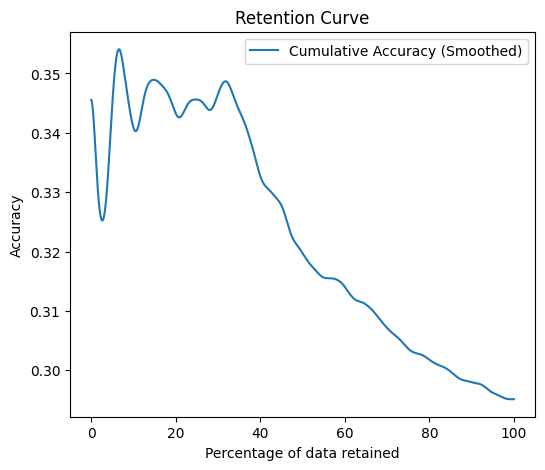

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

with open("local/correct_list.pkl", "rb") as f:
    correct_list = pickle.load(f)
with open("local/uncertainty_list.pkl", "rb") as f:
    uncertainty_list = pickle.load(f)

def plot_retention_curve(correct_list, uncertainty_list):
    # Sort examples by uncertainty
    sorted_indices = np.argsort(uncertainty_list)
    correct_list = np.array(correct_list)[sorted_indices]
    uncertainty_list = np.array(uncertainty_list)[sorted_indices]

    # Calculate cumulative accuracy
    cumulative_correct = np.cumsum(correct_list)
    cumulative_total = np.arange(1, len(correct_list) + 1)
    accuracy = cumulative_correct / cumulative_total

    # Apply Gaussian smoothing
    smoothed_accuracy = gaussian_filter1d(accuracy, sigma=100)

    # Calculate percentage of data retained
    data_percentage = np.linspace(0, 100, len(correct_list))

    # Plot retention curve
    plt.figure(figsize=(6, 5))
    plt.plot(data_percentage, smoothed_accuracy, label='Cumulative Accuracy (Smoothed)')
    # plt.plot(data_percentage, accuracy, alpha=0.3, label='Raw Cumulative Accuracy')
    plt.xlabel('Percentage of data retained')
    plt.ylabel('Accuracy')
    plt.title('Retention Curve')
    # plt.ylim(0.28, 0.37)  # Set y-axis limits between 0.3 and 0.4
    plt.legend()
    plt.show()
    
plot_retention_curve(correct_list, uncertainty_list)
